In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.datasets import load_iris
import missingno as ms

# 1. 사용할 학습기 정하기
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ensemble 넣어주기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.datasets import load_breast_cancer

# 2. preprocessing + model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,cross_val_score, cross_validate

# 3. 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve


### RandomForest (bagging)

##### 장점
- 앙상블방식의 알고리즘 중 수행속도가 빠른다
- 다양한 데이터세트에서의 좋은 성능

##### 단점
- 튜닝을 위한 시간이 오래 걸린다


In [2]:
# HAR 데이터를 이용해서 RandomForest 배깅을 이용한 분류예측
# 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
feature_name_df = pd.read_csv('./data/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [3]:
# 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print(feature_name)


['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tG

In [4]:
# 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
# 컬럼명은 feature_name 적용
# X_train = pd.read_Csv('.data/train/X_train.txt')
#     X_train = pd.read_csv('./data/train/X_train.txt', sep='\s+', names=feature_name)
#     X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+', names=feature_name)

X_train = pd.read_csv('./data/train/X_train.txt', sep='\s+', header=None)
X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+', header=None)


In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [6]:
# 중복 피처에 대한 에러처리 구문
new_feature_name_df = get_new_feature_name_df(feature_name_df)
new_feature_name_df.head()

,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [7]:
# 데이터프레임에 피처명을 컬럼으로 뷰어하기 위해 리스트 객체로 다시 반환
feature_name = new_feature_name_df.iloc[:,1].values.tolist()
feature_name

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

In [8]:
X_train = pd.read_csv('./data/train/X_train.txt', sep='\s+', header=None, names=feature_name)
#X_train.head()

X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+', header=None, names=feature_name)

# 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
y_train = pd.read_csv('./data/train/y_train.txt', sep='\s+', names=['action'])
y_test = pd.read_csv('./data/test/y_test.txt', sep='\s+', names=['action'])



In [9]:
# 랜덤 포레스트 알고리즘을 이용한 학습/예측/평가

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

C:\Users\i\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [10]:
print('answer', y_test)
print('guess', y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('RF ACCURACY: ', accuracy)

answer       action
0          5
1          5
2          5
3          5
4          5
5          5
6          5
7          5
8          5
9          5
10         5
11         5
12         5
13         5
14         5
15         5
16         5
17         5
18         5
19         5
20         5
21         5
22         5
23         5
24         5
25         5
26         5
27         5
28         5
29         5
...      ...
2917       2
2918       2
2919       2
2920       2
2921       2
2922       2
2923       2
2924       2
2925       2
2926       2
2927       2
2928       3
2929       3
2930       3
2931       3
2932       3
2933       3
2934       3
2935       3
2936       3
2937       2
2938       2
2939       2
2940       2
2941       2
2942       2
2943       2
2944       2
2945       2
2946       2

[2947 rows x 1 columns]
guess [5 5 5 ... 2 2 2]
RF ACCURACY:  0.9107567017305734


In [12]:
# GridSearchCV 교차검증 및 하이퍼 파라미터 튜닝
params = {
    'n_estimators':[100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

cv_rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)

# n_jobs : GPU기반에서 n_jobs를 -1로 하면 모든 cpu를 여기에 쓴다

grid_cv = GridSearchCV(cv_rf_model, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

C:\Users\i\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100], 'max_depth': [6, 8, 10, 12], 'min_samples_leaf': [8, 12, 18], 'min_samples_split': [8, 16, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

하이퍼파라미터튜닝을 통해 베스트 스코어와 베스트 파람 가져올 수 있다. 이 베스트값을 랜덤포레스트에 넣어 다시 예측할 수 있다,

In [13]:
print('최적의 파라미터: ', grid_cv.best_params_)
print('예측 정확도: ', grid_cv.best_score_)

최적의 파라미터:  {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}
예측 정확도:  0.9272306855277476


In [30]:
# 최적의 하이퍼 파라미터를 이용하여 랜덤포레스트를 다시 학습시켜보세요

hyper_rf_model = RandomForestClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=8,
                                        n_estimators=100, random_state = 0, n_jobs = -1)

hyper_rf_model.fit(X_train, y_train)
hyper_y_pred = rf_model.predict(X_test)

print('튜닝을 통한 예측 정확도', accuracy_score(y_test, hyper_y_pred))



C:\Users\i\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


튜닝을 통한 예측 정확도 0.9151679674244995


위에는 교차검증했고 아래는 교차검증 안했기 때문에 예측 정확도가 다르다

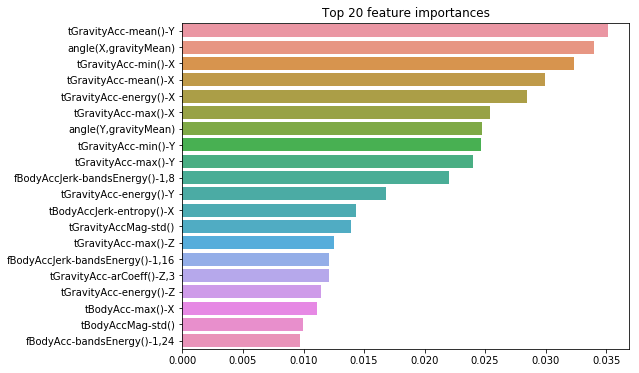

In [29]:
# 각 피처의 중요도를 시각화

ftr_importances_values = hyper_rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Top 20 feature importances')

sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()



### 부스팅(Boosting)
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습, 예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있습니다.